# Simulate acoustic wave propagation with multiple domains


The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook shows the functionality to perform acoustic simulations when multiple domains are present.

## Import the OptimUS library

Load the OptimUS library. Make sure the source code is in the Python path.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

In [3]:
print("OptimUS version:", optimus.__version__)

OptimUS version: 0.0.0


## Specify the physical settings for the simulation

Let us consider two spherical objects embedded in an unbounded region of water. One of the domains consists of fat and the other of cortical bone. The incident plane wave has a frequency of 100 kHz and the two spheres have a radius of 7 and 5 mm, respectively.

In [4]:
frequency = 100e3
source = optimus.source.create_planewave(frequency)

In [5]:
radii = (7e-3, 5e-3)
origins = ((-10e-3,0,0), (10e-3,0,0))
meshwidth = 2e-3

In [6]:
geometry_left = optimus.geometry.shapes.Sphere(r=radii[0], origin=origins[0], h=meshwidth)
geometry_right = optimus.geometry.shapes.Sphere(r=radii[1], origin=origins[1], h=meshwidth)
geometries = (geometry_left, geometry_right)

A list of materials can be loaded at once.

In [7]:
material_ext = optimus.material.load_material('water')
materials_int = optimus.material.load_material(('fat', 'bone (cortical)'))
material_left, material_right = materials_int

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. The model with default settings needs the physical parameters as input. The interior domains are specified as a tuple or list of the geometries and the materials, while the exterior medium needs to be specified separately.

In [8]:
model = optimus.model.create_default_model(source, geometries, material_ext, materials_int)

Solving the model requires the GMRES algorithm to solve the system of boundary integral equations. This can be computationally expensive depending on the grid resolution.

In [9]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [10]:
import numpy as np
import bempp.api
from matplotlib import pylab as plt

In [11]:
# Create a visualisation grid
Nx = 160
Ny = 120
xmin, xmax, ymin, ymax = [-20e-3, 20e-3, -15e-3, 15e-3]
zval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    zval*np.ones(plot_grid[0].size)))

# Define the interior and exterior points
x, y = points[:2]
idx_left = np.sqrt((x-origins[0][0])**2 + (y-origins[0][1])**2) < radii[0]
idx_right = np.sqrt((x-origins[1][0])**2 + (y-origins[1][1])**2) < radii[1]
idx_ext = np.logical_not(np.logical_or(idx_left,idx_right))
points_left = points[:, idx_left]
points_right = points[:, idx_right]
points_ext = points[:, idx_ext]

In [12]:
# Calculate the fields from the surface potential with the potential operators
slp_pot_int_left = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_left, material_left.compute_wavenumber(source.frequency))
dlp_pot_int_left = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_left, material_left.compute_wavenumber(source.frequency))
slp_pot_int_right = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[1], points_right, material_right.compute_wavenumber(source.frequency))
dlp_pot_int_right = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[1], points_right, material_right.compute_wavenumber(source.frequency))

slp_pot_ext_left = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[0], points_ext, material_ext.compute_wavenumber(source.frequency))
dlp_pot_ext_left = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[0], points_ext, material_ext.compute_wavenumber(source.frequency))
slp_pot_ext_right = bempp.api.operators.potential.helmholtz.single_layer(
    model.space[1], points_ext, material_ext.compute_wavenumber(source.frequency))
dlp_pot_ext_right = bempp.api.operators.potential.helmholtz.double_layer(
    model.space[1], points_ext, material_ext.compute_wavenumber(source.frequency))

surfpot_dir_ext_left, surfpot_neu_ext_left, surfpot_dir_ext_right, surfpot_neu_ext_right = model.solution
surfpot_dir_int_left = surfpot_dir_ext_left
surfpot_dir_int_right = surfpot_dir_ext_right
surfpot_neu_int_left = (material_left.density / material_ext.density) * surfpot_neu_ext_left
surfpot_neu_int_right = (material_right.density / material_ext.density) * surfpot_neu_ext_right
total_field_left = (slp_pot_int_left * surfpot_neu_int_left - dlp_pot_int_left * surfpot_dir_int_left).ravel()
total_field_right = (slp_pot_int_right * surfpot_neu_int_right - dlp_pot_int_right * surfpot_dir_int_right).ravel()
scat_field_ext_left = (dlp_pot_ext_left * surfpot_dir_ext_left - slp_pot_ext_left * surfpot_neu_ext_left).ravel()
scat_field_ext_right = (dlp_pot_ext_right * surfpot_dir_ext_right - slp_pot_ext_right * surfpot_neu_ext_right).ravel()
inc_field_ext = source.pressure_field(points_ext, material_ext.compute_wavenumber(source.frequency))
total_field_ext = scat_field_ext_left + scat_field_ext_right + inc_field_ext

total_field = np.zeros(points.shape[1], dtype='complex128')
total_field[idx_left] = total_field_left
total_field[idx_right] = total_field_right
total_field[idx_ext] = total_field_ext
total_field = total_field.reshape([Nx, Ny])

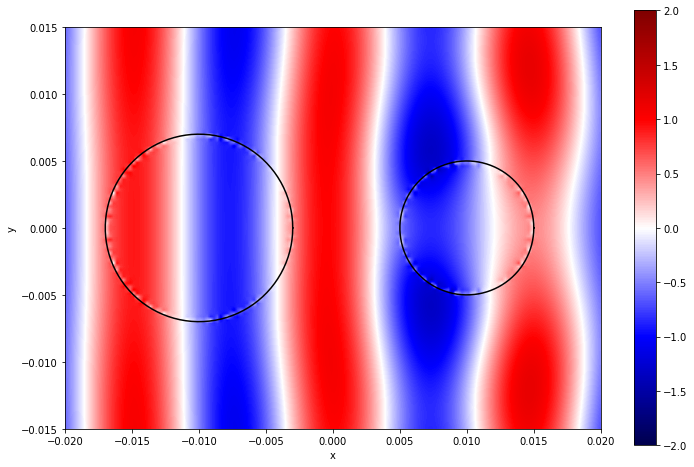

In [13]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(np.real(np.flipud(total_field.T)), extent=(xmin, xmax, ymin, ymax), clim=(-2,2), cmap='seismic', interpolation='bilinear')
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(origins[0][0]+radii[0]*np.cos(theta), origins[0][1]+radii[0]*np.sin(theta), 'k')
plt.plot(origins[1][0]+radii[1]*np.cos(theta), origins[1][1]+radii[1]*np.sin(theta), 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()